In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict

In [2]:
from ranking_funcs import read_imdb_actor_data,Comp_Greedy_Algo_backdoor,get_prob_backdoor_opt,rec_row_prob_back,backdoor_adjustment_opt,find_backdoor_sets_opt,Greedy_Algo,get_most_probable_elements,get_cgm,get_prob_backdoor_opt,get_probs,get_prob_backdoor,filter_prob_df_grouped,read_data,get_ranking_query_prob_grouped,get_stable_ranking_opt,get_ranking_query,get_ranking_query_prob,get_test_revert_ranking_rec,get_new_G,filter_prob_df,calc_prob,base_line

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


- Television Series:'tvSeries','tvMiniSeries'

- Television Specials:'tvSpecial','tvMovie','tvShort','tvEpisode'

- Film Content:'movie'

- Short Formats:'short'

- Interactive/Other Formats:'video','videoGame'

In [3]:
def read_imdb_actor_data(path):
    df = pd.read_csv(path)
    df['averageRating'] = round(df['averageRating'], 0)
    df['isAdult'] = df['isAdult'].apply(lambda x: 1 if x == 1 else 0)

    def runtime_category(runtime):
        if runtime <= 5: return 0
        elif runtime <= 15: return 1
        elif runtime <= 30: return 2
        else: return 3
    df['runtimeMinutes'] = df['runtimeMinutes'].apply(runtime_category)

    def votes_category(votes):
        if votes <= 15: return 0
        elif votes <= 35: return 1
        elif votes <= 100: return 2
        else: return 3
    df['numVotes'] = df['numVotes'].apply(votes_category)

    name_map = {'Michael Smith': 0, 'David Smith': 1, 'Michael Johnson': 2,
                'Chris Smith': 3, 'David Brown': 4, 'David Jones': 5}
    df['primaryName'] = df['primaryName'].apply(lambda x: name_map.get(x, -1))

    title_type_map = {'tvSeries': 0, 'tvMiniSeries': 0, 'tvSpecial': 1,
                      'tvMovie': 1, 'tvShort': 1, 'tvEpisode': 1,
                      'movie': 2, 'short': 3, 'video': 4, 'videoGame': 4}
    df['titleType'] = df['titleType'].apply(lambda x: title_type_map.get(x, -1))
    return df



In [4]:
df=read_imdb_actor_data('ranking_data_sets/cleaned_imdb_name.csv')
df.head()

,primaryName,tconst_x,averageRating,numVotes,titleType,primaryTitle,isAdult,runtimeMinutes
0,2,tt0159163,8.0,2,0,The Expert,0,3
1,2,tt0057757,8.0,3,0,The Human Jungle,0,3
2,2,tt0159897,7.0,2,0,The Newcomers,0,2
3,2,tt0064030,7.0,3,2,Anne of the Thousand Days,0,3
4,2,tt0103460,6.0,3,0,Kung Fu: The Legend Continues,0,3


- primaryName might influence the type of titles they are in, which could affect ratings. So, primaryName → titleType → averageRating.
- primaryName might influence the viewership of a title, potentially affecting the number of votes. More popular actors might attract more attention to a title, indirectly influencing its rating through increased visibility or expectations. So, primaryName → numVotes → averageRating.
- The length of the content might be tailored or selected based on the actor's typical roles or preferences, which could then influence ratings. So, primaryName → runtimeMinutes → averageRating.
- Whether a film is intended for adults might be influenced by the typical roles or image of an actor, which could then influence its rating. So, primaryName → isAdult → averageRating.


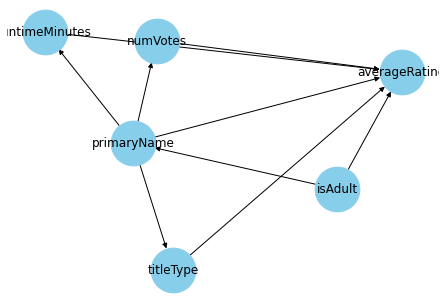

In [5]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "titleType", "isAdult", "runtimeMinutes", "primaryName"]
G.add_nodes_from(nodes)

edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "titleType"),     
    ("titleType", "averageRating"),
    ("primaryName", "numVotes"),
    ("numVotes", "averageRating"),
    ("primaryName", "runtimeMinutes"),
    ("runtimeMinutes", "averageRating"),
    ("isAdult", "primaryName"),
    ("isAdult", "averageRating")
]
G.add_edges_from(edges)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2000, edge_cmap=plt.cm.Blues)
plt.show()

In [6]:
new_G=get_new_G(G,df)

In [7]:
nds=["isAdult", "runtimeMinutes", "averageRating", "primaryName"]

In [8]:
for n in nds:
    print((n,find_backdoor_sets_opt(G, "averageRating", n)))

('isAdult', None)
('runtimeMinutes', [frozenset({'primaryName'})])
('averageRating', None)
('primaryName', [frozenset({'isAdult'})])


In [9]:
df.sort_values(by='averageRating',ascending=False).head(5)

,primaryName,tconst_x,averageRating,numVotes,titleType,primaryTitle,isAdult,runtimeMinutes
192,2,tt11524214,10.0,1,0,Water Helps the Blood Run,0,2
964,2,tt6057470,10.0,0,3,The Last Visit,0,2
819,0,tt10846308,10.0,0,3,Divided We Stand,0,2
971,0,tt7586230,10.0,0,3,Tertium Quid,0,2
834,1,tt3507346,10.0,0,3,Haiti Speaks,0,3


In [10]:
popular_actors=['Michael Smith',
                'David Smith',
                'Michael Johnson',
                'Chris Smith',
                'David Brown'
                'David Jones']

In [11]:
df_bo=get_prob_backdoor_opt(new_G, df, 5, {'primaryName':0}, 'averageRating', {'primaryName':1}, 'fix', [819,971], 10)

df_bo

0    0.000049
Name: prob, dtype: float64

In [19]:
var=['runtimeMinutes']
df_gr=Greedy_Algo(new_G, df, 5, 'averageRating',var,0, None,100, opt="add",force=2)
df_gr

,rank,prob,total_iters
0,"[192, 964, 819, 971, 834]",1.0,100.0


In [ ]:
row_indexes=[819]
greedy_backdoor=Comp_Greedy_Algo_backdoor(row_indexes,new_G, df, 5, 'averageRating',var,1, None ,100, opt="add",force=2)

In [ ]:
mean_value = sum(greedy_backdoor) / len(greedy_backdoor)
print(mean_value)

In [23]:
df.iloc[819]

primaryName                      0
tconst_x                tt10846308
averageRating                 10.0
numVotes                         0
titleType                        3
primaryTitle      Divided We Stand
isAdult                          0
runtimeMinutes                   2
Name: 819, dtype: object

In [15]:
def k_range_backdoor(G, df, k, update_vars, target_column, condition, opt, row_indexes,end_k):
    back_result=[]
    for z in range(k,end_k+1):
        updated_df=get_ranking_query(G, df, len(df), update_vars, target_column, condition, opt).sort_values(by=target_column,ascending=False)
        theta=updated_df[target_column].iloc[z-1]
        back_result.append(get_prob_backdoor_opt(G, df, z, update_vars,
                                                 target_column, condition, opt, row_indexes, theta))
    return back_result
        

In [17]:
k_range_backdoor_val=k_range_backdoor(new_G, df, 5, {'primaryName':0}, 'averageRating', {'primaryName':2}, 'fix', [819,971],1000)

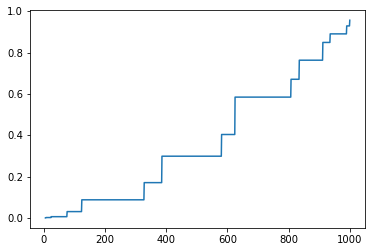

In [18]:
x_values = range(5, 1001)     
plt.plot(x_values, k_range_backdoor_val)
plt.show()

In [ ]:
updated_df=get_ranking_query(new_G, df, len(df), {'primaryName':0}, 'averageRating', {'primaryName':2}, 'fix').sort_values(by='averageRating',ascending=False)